In [1]:
import requests
import pandas as pd
import numpy as np
import os
os.chdir('..')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
cmgs = [item for item in os.listdir('data/daily_data/') if 'cmg' in item.split('_')]
cmgs.sort()

In [4]:
first_df = pd.read_csv('data/daily_data/{}'.format(cmgs[0]))
for cmg in cmgs[1:]:
    this_df = pd.read_csv('data/daily_data/{}'.format(cmg))
    first_df = pd.concat([first_df, this_df])

In [5]:
# cols = first_df.columns.tolist()
# cols_to_drop = cols[:4] + ['label', 'changeOverTime', 'close', 'high', 'low', 'marketAverage',
#                            'marketClose', 'marketOpen', 'volume', 'numberOfTrades', 
#                            'notional', 'open', 'marketChangeOverTime']

In [6]:
# first_df.drop(cols_to_drop, axis=1, inplace=True)
# # necessary
# first_df.reset_index(drop=True, inplace=True)

In [7]:
# idx_to_drop = first_df.index[first_df.marketNotional == 0.0]
# first_df.drop(idx_to_drop, inplace=True)
# first_df.reset_index(drop=True, inplace=True)
# first_df.describe()

In [8]:
# first_df.date = first_df.date.map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
# first_df['weekday'] = first_df.date.map(lambda x: str(x.weekday()))
# first_df['month'] = first_df.date.map(lambda x: str(x.month))

In [9]:
# first_df.minute = first_df.minute.map(lambda x: datetime.datetime.strptime(x, '%H:%M'))
# first_df['hour'] = first_df.minute.map(lambda x: str(x.hour))

In [10]:
import datetime
def get_processed_minute_data(df):
    cols = df.columns.tolist()
    cols_to_drop = cols[:4] + ['label', 'changeOverTime', 'close', 'high', 
                               'low', 'marketAverage', 'marketClose', 
                               'marketOpen', 'volume', 'numberOfTrades', 
                               'notional', 'open', 'marketChangeOverTime']
    df.drop(cols_to_drop, axis=1, inplace=True)
    # necessary
    df.reset_index(drop=True, inplace=True)
    
    idx_to_drop = df.index[df.marketNotional == 0.0]
    df.drop(idx_to_drop, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df.date = df.date.map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    df['weekday'] = df.date.map(lambda x: str(x.weekday()))
    df['month']   = df.date.map(lambda x: str(x.month))
    
    df.minute = first_df.minute.map(lambda x: datetime.datetime.strptime(x, '%H:%M'))
    df['hour'] = first_df.minute.map(lambda x: str(x.hour))
    
    return df

first_df = get_processed_minute_data(first_df)

In [11]:
def get_numeric_categoric(df):
    numeric_cols, categorical_cols = [], []

    for col in first_df:
        if np.issubdtype(df[col].dtype, np.number):
            numeric_cols += [col]
        else:
            categorical_cols += [col]
    
    return numeric_cols, categorical_cols

In [12]:
numericl_cols, categorical_cols = get_numeric_categoric(first_df)
numericl_cols, categorical_cols

(['marketHigh',
  'marketLow',
  'marketNotional',
  'marketNumberOfTrades',
  'marketVolume'],
 ['date', 'minute', 'weekday', 'month', 'hour'])

In [13]:
def delta_dataframe(df, numeric_columns):
    '''
    log numerical columns, then return deltas
    '''
    
    added_columns = []
    for shift in [3, 5, 10, 20]:
        for col in numeric_columns:
            new_col_name = col + '_' + str(shift)
            df[new_col_name] = df[col].shift(shift)
            added_columns += [new_col_name]

    df[numeric_columns+added_columns] = df[numeric_columns+added_columns].apply(np.log)
    
    # for lookbacks
    for new_col in added_columns:
        original_col = new_col.split('_')[0]
        df[new_col] = df[original_col] - df[new_col]
    
    # for today
    # This line is necessary
    temp = df[numeric_columns] - df[numeric_columns].shift(1)
    df[numeric_columns] = temp
    
    assert (df.index == np.arange(len(first_df))).all()
    df.drop(df.index[list(range(20))], axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [14]:
first_df = delta_dataframe(first_df, numericl_cols)
first_df.describe()

,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketVolume,marketHigh_3,marketLow_3,marketNotional_3,marketNumberOfTrades_3,marketVolume_3,...,marketHigh_10,marketLow_10,marketNotional_10,marketNumberOfTrades_10,marketVolume_10,marketHigh_20,marketLow_20,marketNotional_20,marketNumberOfTrades_20,marketVolume_20
count,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,...,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000
mean,0.000010,0.000009,0.000546,0.000509,0.000536,0.000029,0.000029,0.001056,0.000944,0.001027,...,0.000095,0.000096,0.002527,0.002288,0.002431,0.000192,0.000196,0.004639,0.003990,0.004445
std,0.001060,0.001136,1.875454,1.314247,1.875470,0.001815,0.001860,1.870390,1.299166,1.870408,...,0.003303,0.003336,1.917313,1.340305,1.917343,0.004753,0.004798,1.977734,1.375164,1.977768
min,-0.009287,-0.016011,-9.737805,-5.780744,-9.737905,-0.014290,-0.018523,-8.453899,-5.641907,-8.454253,...,-0.020738,-0.021170,-8.408788,-4.974432,-8.419801,-0.027329,-0.028410,-9.142410,-5.068904,-9.132487
25%,-0.000461,-0.000424,-1.028174,-0.840009,-1.028319,-0.000893,-0.000854,-0.993720,-0.810930,-0.993972,...,-0.001731,-0.001652,-1.040293,-0.847298,-1.040839,-0.002442,-0.002373,-1.086983,-0.875469,-1.087573
50%,-0.000006,0.000021,-0.019464,0.000000,-0.019489,-0.000015,0.000042,0.007532,0.000000,0.006793,...,-0.000043,0.000011,0.021727,0.000000,0.021350,0.000069,0.000149,0.033382,0.000000,0.036022
75%,0.000435,0.000475,0.990990,0.810930,0.991232,0.000850,0.000885,1.005874,0.810930,1.006254,...,0.001680,0.001756,1.063547,0.869038,1.062480,0.002584,0.002703,1.116235,0.916291,1.115391
max,0.020955,0.021290,8.791507,4.532599,8.787983,0.024005,0.017813,8.805578,4.488636,8.806124,...,0.023029,0.021556,8.543134,4.795791,8.546364,0.031003,0.032480,8.377414,4.905275,8.367532


In [15]:
categorical_cols

['date', 'minute', 'weekday', 'month', 'hour']

In [16]:
numericl_cols, categorical_cols = get_numeric_categoric(first_df)

In [17]:
categorical_cols.remove('minute')
categorical_cols

['date', 'weekday', 'month', 'hour']

In [224]:
first_df[categorical_cols] = first_df[categorical_cols].applymap(lambda x: int(x))

In [225]:
label = first_df[['marketHigh', 'marketLow']]    
label_10, label_5 = label.shift(-10), label.shift(-5)

idx_to_del = np.arange(len(label_10)-10, len(label_10))
label_10.drop(idx_to_del, inplace=True)
label_5.drop(idx_to_del, inplace=True)
first_df.drop(idx_to_del, inplace=True)


In [226]:
import tensorflow as tf
import tensorflow.contrib.timeseries as ts
import multiprocessing
import pandas as pd
import numpy as np
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

In [227]:
first_df.dtypes

date                                int64
marketHigh                        float64
marketLow                         float64
marketNotional                    float64
marketNumberOfTrades              float64
marketVolume                      float64
minute                     datetime64[ns]
weekday                             int64
month                               int64
hour                                int64
marketHigh_3                      float64
marketLow_3                       float64
marketNotional_3                  float64
marketNumberOfTrades_3            float64
marketVolume_3                    float64
marketHigh_5                      float64
marketLow_5                       float64
marketNotional_5                  float64
marketNumberOfTrades_5            float64
marketVolume_5                    float64
marketHigh_10                     float64
marketLow_10                      float64
marketNotional_10                 float64
marketNumberOfTrades_10           

In [228]:
first_df.date = np.arange(len(first_df))

In [229]:
unique_list = {}
for item in categorical_cols[1:]:
    unique_list[item] = first_df[item].unique().tolist()

In [230]:
unique_list

{'weekday': [0, 1, 2, 3, 4],
 'month': [10, 11],
 'hour': [9, 10, 11, 12, 13, 14, 15]}

In [231]:
import tensorflow.feature_column as fc

In [232]:
category_dict = {item: fc.categorical_column_with_vocabulary_list(
                        item, unique_list[item]) 
                for item in categorical_cols[1:]}
category_dict

{'weekday': _VocabularyListCategoricalColumn(key='weekday', vocabulary_list=(0, 1, 2, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 'month': _VocabularyListCategoricalColumn(key='month', vocabulary_list=(10, 11), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 'hour': _VocabularyListCategoricalColumn(key='hour', vocabulary_list=(9, 10, 11, 12, 13, 14, 15), dtype=tf.int64, default_value=-1, num_oov_buckets=0)}

In [233]:
embedding_categories = {
    item: fc.embedding_column(category_dict[item], 2)
    for item in category_dict
}
embedding_categories

{'weekday': _EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='weekday', vocabulary_list=(0, 1, 2, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', layer_creator=<function embedding_column.<locals>._creator at 0x7f8dab77f6a8>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True),
 'month': _EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='month', vocabulary_list=(10, 11), dtype=tf.int64, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', layer_creator=<function embedding_column.<locals>._creator at 0x7f8dab77f8c8>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True),
 'hour': _EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='hour', vocabulary_list=(9, 10, 11, 12, 13, 14, 15), dtype=tf.int64, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', layer_creator=<function embedding_column.<lo

In [234]:
# HEADER = first_df.columns.tolist()
TIME_INDEX_FEATURE_NAME = 'date'
VALUE_FEATURE_NAMES = numericl_cols
CAT_FEATURE_NAMES = categorical_cols[1:]

In [235]:
def generate_input_fn(dataframe, mode, 
                      header_lines=1, batch_size=None, 
                      windows_size=None, tail_count=None):
    
    if tail_count is not None:
        dataframe = dataframe.tail(tail_count)
    
    print("Dataset Size: {}".format(len(dataframe)))
    print("")
    
    data = {
        ts.TrainEvalFeatures.TIMES: 
                    dataframe[TIME_INDEX_FEATURE_NAME],
        ts.TrainEvalFeatures.VALUES: 
                    dataframe[VALUE_FEATURE_NAMES+CAT_FEATURE_NAMES],
        'weekday': dataframe[['weekday']],
        'month':   dataframe[['month']],
        'hour' :   dataframe[['hour']],
    }
    
    reader = ts.NumpyReader(data)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        input_fn = tf.contrib.timeseries.RandomWindowInputFn(
            reader, 
            batch_size=batch_size, 
            window_size=windows_size,
        )
        
    elif mode == tf.estimator.ModeKeys.EVAL:
        input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
    
    return input_fn

In [236]:
embed_list = list(embedding_categories.values())

In [237]:
from tensorflow.contrib.timeseries.python.timeseries import estimators as ts_estimators
from tensorflow.contrib.timeseries.examples.lstm import _LSTMModel

In [238]:
def create_lstm_estimator(run_config, hparams):
    estimator= ts_estimators.TimeSeriesRegressor(
        model=_LSTMModel(num_units=hparams.num_units, 
                         num_features=hparams.num_features, 
                         exogenous_feature_columns=hparams.exogenous_feature_columns), 
        optimizer = tf.train.AdagradOptimizer(learning_rate=hparams.learning_rate),
        config=run_config,)
    return estimator

In [239]:
def create_estimator(run_config, hparams):

    estimator = ts.ARRegressor(
        periodicities= hparams.periodicities, 
        input_window_size= hparams.input_window_size, 
        output_window_size= hparams.output_window_size,
        num_features=len(VALUE_FEATURE_NAMES+CAT_FEATURE_NAMES),
        exogenous_feature_columns=embed_list,
        loss=hparams.loss,
        hidden_layer_sizes = hparams.hidden_units,
        optimizer = tf.train.AdagradOptimizer(learning_rate=hparams.learning_rate),
        config=run_config
    )
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

In [260]:
hparams  = tf.contrib.training.HParams(
    num_units=64,
    num_features=len(VALUE_FEATURE_NAMES+CAT_FEATURE_NAMES),
    exogenous_feature_columns=embed_list,
    
    training_steps = 10000,
    periodicities = [10],
    input_window_size = 32,
    output_window_size=5,
    batch_size = 16,
    loss = tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS, # NORMAL_LIKELIHOOD_LOSS | SQUARED_LOSS
    hidden_units = [32,32,16],
    learning_rate = 1e-3,
)

In [261]:
CHECKPOINT_STEPS=1000
MODEL_NAME = 'ts-model-03'

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.estimator.RunConfig().replace(
    save_checkpoints_steps=CHECKPOINT_STEPS,
    tf_random_seed=19830610,
    model_dir=model_dir,
)
                                             
print("Model directory: {}".format(run_config.model_dir))
print("Hyper-parameters: {}".format(hparams))
print("")

train_input_fn = generate_input_fn(
    dataframe=first_df,
    mode = tf.estimator.ModeKeys.TRAIN,
    batch_size=hparams.batch_size,
    windows_size = hparams.input_window_size + hparams.output_window_size
)

Model directory: trained_models/ts-model-03
Hyper-parameters: [('batch_size', 16), ('exogenous_feature_columns', [_EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='weekday', vocabulary_list=(0, 1, 2, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', layer_creator=<function embedding_column.<locals>._creator at 0x7f8dab77f6a8>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True), _EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='month', vocabulary_list=(10, 11), dtype=tf.int64, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', layer_creator=<function embedding_column.<locals>._creator at 0x7f8dab77f8c8>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True), _EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='hour', vocabulary_list=(9, 10, 11, 12, 13, 14, 15), dtype=tf.int64, default_value=-1, num_oov_buc

In [262]:
# estimator = create_estimator(run_config, hparams)
estimator = create_lstm_estimator(run_config, hparams)

In [263]:
estimator = create_estimator(run_config, hparams)


Estimator Type: <class 'tensorflow.contrib.timeseries.python.timeseries.estimators.ARRegressor'>



In [264]:
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Estimator training started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................")

estimator.train(input_fn=train_input_fn, steps=hparams.training_steps)

time_end = datetime.utcnow() 
print(".......................................")
print("Estimator training finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Estimator training elapsed time: {} seconds".format(time_elapsed.total_seconds()))

Estimator training started at 06:46:53
.......................................
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from trained_models/ts-model-03/model.ckpt-23000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 23000 into trained_models/ts-model-03/model.ckpt.
INFO:tensorflow:loss = 1.3750893, step = 23000
INFO:tensorflow:global_step/sec: 81.1752
INFO:tensorflow:loss = 1.3986788, step = 23100 (1.233 sec)
INFO:tensorflow:global_step/sec: 88.5756
INFO:tensorflow:loss = 1.375542, step = 23201 (1.129 sec)
INFO:tensorflow:global_step/sec: 93.3139
INFO:tensorflow:loss = 1.459896, step = 23300 (1.071 sec)
INFO:tensorflow:global_step/sec: 82.9361
INFO:tensorflow:loss = 1.2501048, step = 23400 (1.207 sec)
INFO:tensorflow:global_step/sec: 105.734
INFO:tensorflow:loss = 

INFO:tensorflow:global_step/sec: 131.102
INFO:tensorflow:loss = 1.4102752, step = 30200 (0.763 sec)
INFO:tensorflow:global_step/sec: 128.29
INFO:tensorflow:loss = 1.4420382, step = 30300 (0.778 sec)
INFO:tensorflow:global_step/sec: 126.159
INFO:tensorflow:loss = 1.3446218, step = 30400 (0.794 sec)
INFO:tensorflow:global_step/sec: 132.421
INFO:tensorflow:loss = 1.2643112, step = 30500 (0.755 sec)
INFO:tensorflow:global_step/sec: 121.561
INFO:tensorflow:loss = 1.394161, step = 30600 (0.823 sec)
INFO:tensorflow:global_step/sec: 125.013
INFO:tensorflow:loss = 1.3653389, step = 30700 (0.799 sec)
INFO:tensorflow:global_step/sec: 123.635
INFO:tensorflow:loss = 1.3679787, step = 30800 (0.810 sec)
INFO:tensorflow:global_step/sec: 121.932
INFO:tensorflow:loss = 1.4225067, step = 30900 (0.830 sec)
INFO:tensorflow:Saving checkpoints for 31000 into trained_models/ts-model-03/model.ckpt.
INFO:tensorflow:global_step/sec: 108.712
INFO:tensorflow:loss = 1.6557516, step = 31000 (0.909 sec)
INFO:tensorfl

In [266]:
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Estimator training started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................")

estimator.train(input_fn=train_input_fn, steps=hparams.training_steps)

time_end = datetime.utcnow() 
print(".......................................")
print("Estimator training finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Estimator training elapsed time: {} seconds".format(time_elapsed.total_seconds()))

Estimator training started at 06:48:33
.......................................
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from trained_models/ts-model-03/model.ckpt-33000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 33000 into trained_models/ts-model-03/model.ckpt.
INFO:tensorflow:loss = 1.279439, step = 33000
INFO:tensorflow:global_step/sec: 83.9716
INFO:tensorflow:loss = 1.3715069, step = 33100 (1.192 sec)
INFO:tensorflow:global_step/sec: 89.7549
INFO:tensorflow:loss = 1.4180506, step = 33200 (1.115 sec)
INFO:tensorflow:global_step/sec: 89.7818
INFO:tensorflow:loss = 1.3961055, step = 33300 (1.125 sec)
INFO:tensorflow:global_step/sec: 74.4555
INFO:tensorflow:loss = 1.4792117, step = 33400 (1.332 sec)


KeyboardInterrupt: 

In [267]:
hparams  = tf.contrib.training.HParams(
    training_steps = 1,
    periodicities = [10],
    input_window_size = 32,
    output_window_size= 5,
    batch_size = 16,
    loss = tf.contrib.timeseries.ARModel.SQUARED_LOSS, # NORMAL_LIKELIHOOD_LOSS | SQUARED_LOSS
    hidden_units = [32,32,16],
    learning_rate = 0.001
    
)

estimator = create_estimator(run_config, hparams)

eval_input_fn = generate_input_fn(
    first_df,
    mode = tf.estimator.ModeKeys.EVAL,
)

tf.logging.set_verbosity(tf.logging.WARN)
evaluation = estimator.evaluate(input_fn=eval_input_fn, steps=1)
print("")
print(evaluation.keys())
print("")
print("Evaluation Loss ({}) : {}".format(hparams.loss, evaluation['loss']))

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/ts-model-03', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8d9a913b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.contrib.timeseries.python.timeseries.estimators.ARRegressor'>

Dataset Size: 9616


dict_keys(['covariance', 'loss', 'mean', 'observed', 'start_tuple', 'times', 'global_step'])

Evaluation Loss (squared_loss) : 1.828465461730957


In [268]:
def compute_rmse(a, b):
    rmse =  np.sqrt(np.sum(np.square(a - b)) / len(a))
    return round(rmse,5)

def compute_mae(a, b):
    mae =  np.sqrt(np.sum(np.abs(a - b)) / len(a))
    return round(mae,5)

x_current = evaluation['times'][0]
y_current_actual = evaluation['observed'][0]
y_current_estimated = evaluation['mean'][0]

test_col = -9

rmse = compute_rmse(y_current_actual[:, test_col], y_current_estimated[:, test_col])
mae = compute_mae(y_current_actual[:, test_col], y_current_estimated[:, test_col])
print("Evaluation RMSE {}".format(rmse))
print("Evaluation MAE {}".format(mae))

Evaluation RMSE 1.92142
Evaluation MAE 1.1917


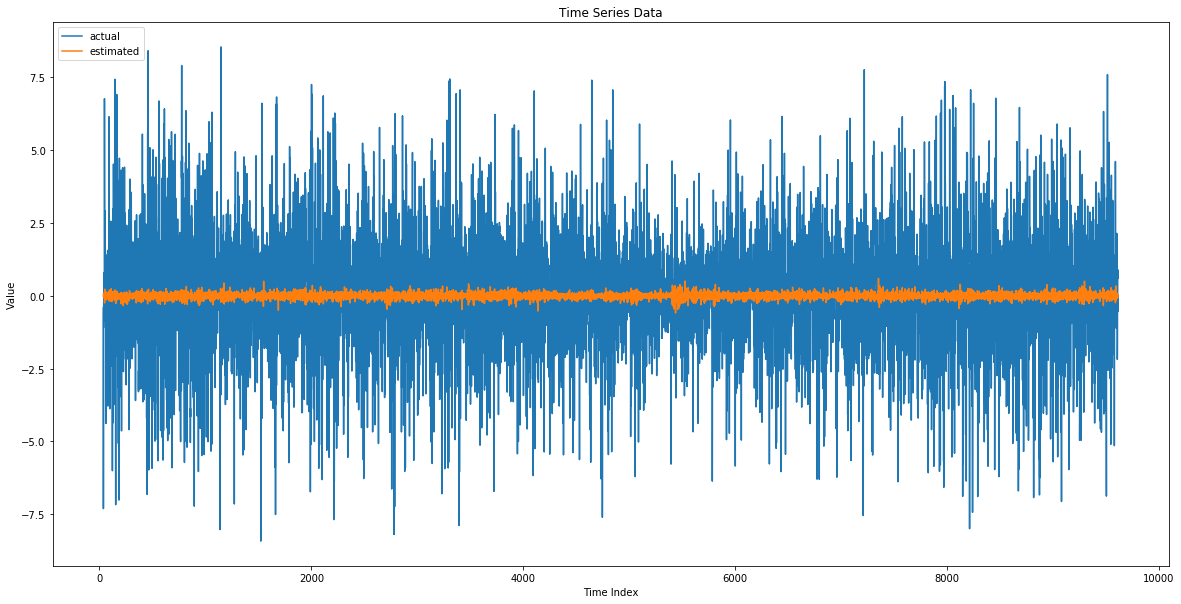

In [269]:
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_current, y_current_actual[:, test_col], label='actual')
plt.plot(x_current, y_current_estimated[:,test_col], label='estimated')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()